<a href="https://colab.research.google.com/github/jayarnim/M1-DeepLearning/blob/main/skills/3_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model

# Sequential API

In [2]:
inputs = layers.Input(shape = (3,), name = "Input_Layer")
features = layers.Dense(units = 64, activation = "relu", name = "Feature_Layer")
outputs = layers.Dense(units = 10, activation = "softmax", name = "Output_Layer")

In [3]:
model = Sequential(name = "My_Sequential_Model")
model.add(inputs)
model.add(features)
model.add(outputs)

In [4]:
# Input Layer 을 추가하지 않았을 경우 가중치 및 편향 수동 초기화
# model.build(input_shape = (None, 3))
# model.weights

In [5]:
model.summary()

Model: "My_Sequential_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Layer (Dense)       (None, 64)                256       
                                                                 
 Output_Layer (Dense)        (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Functional API

## 단일 입력, 단일 출력

In [6]:
# 계층 생성 시 이전 계층 반환값을 입력 아규먼트로 명시함
inputs = layers.Input(shape = (3,))
features = layers.Dense(units = 64, activation = "relu")(inputs)
outputs = layers.Dense(units = 10, activation = "softmax")(features)

In [7]:
model = Model(
    inputs = inputs,
    outputs = outputs,
    name = "My_Functional_Model"
    )

In [8]:
model.summary()

Model: "My_Functional_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 다중 입력, 다중 출력

- 고객 이슈 티켓에 우선순위 지정 및 처리 부서 판별하는 분석 모델 생성

- 입력값
    - 이슈 티켓 제목
    - 이슈 티켓 텍스트 본문
    - 사용자가 추가한 태그

- 출력값
    - 이슈 티켓 우선순위 점수로서 0~1 사이 스칼라
    - 이슈 티켓 처리 부서

In [9]:
# 가상의 데이터 생성
num_samples = 1280

vocabulary_size = 10000
num_tags = 100
num_departments = 4

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

In [10]:
# 다중 입력
title = layers.Input(shape = (vocabulary_size,), name = "title")
text_body = layers.Input(shape = (vocabulary_size,), name = "text_body")
tags = layers.Input(shape = (num_tags,), name = "tags")
inputs = [title, text_body, tags]

In [11]:
# 입력값 병합
concats = layers.Concatenate()(inputs)

In [12]:
# 은닉층
features = layers.Dense(units = 64, activation = "relu")(concats)

In [13]:
# 다중 출력
priority = layers.Dense(units = 1, activation = "sigmoid", name = "priority")(features)
department = layers.Dense(units = num_departments, activation = "softmax", name = "department")(features)
outputs = [priority, department]

In [14]:
model = Model(
    inputs = inputs,
    outputs = outputs,
    name = "My_Functional_Model_Multi"
    )

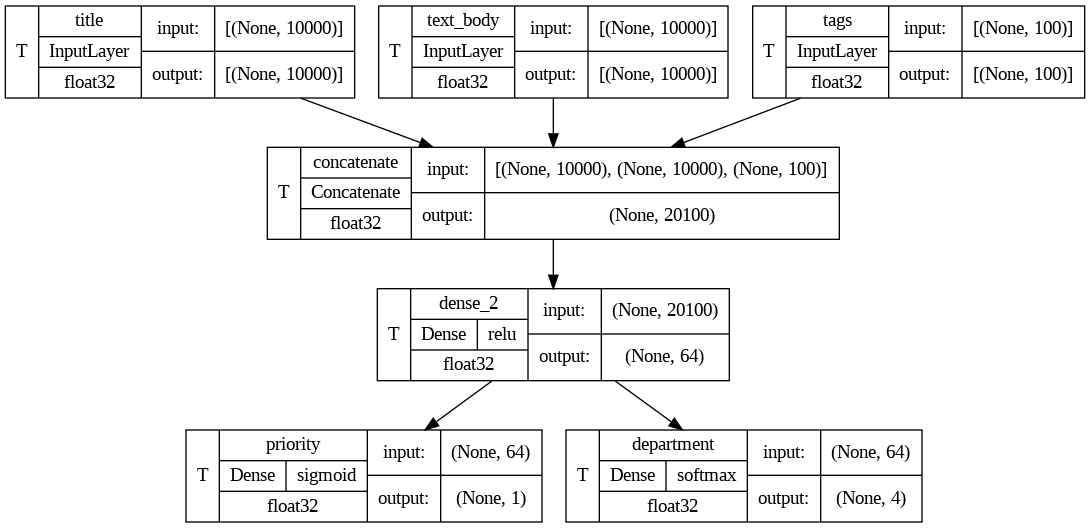

In [15]:
keras.utils.plot_model(
    model = model,
    # to_file = "model.png",
    show_shapes = True,
    show_dtype = True,
    show_layer_names = True,
    show_layer_activations = True,
    show_trainable = True
    )

In [16]:
# key 를 layer name 과 동일하게 설정
model.compile(
    optimizer = "rmsprop",
    loss = {
        "priority":"mean_squared_error",
        "department":"categorical_crossentropy"
        },
    metrics = {
        "priority":["mean_absolute_error"],
        "department":["accuracy"]
        }
    )

history = model.fit(
    x = {
        "title":title_data,
        "text_body":text_body_data,
        "tags":tags_data
        },
    y = {
        "priority":priority_data,
        "department":department_data
        },
    epochs = 1
    )

model.evaluate(
    x = {
        "title":title_data,
        "text_body":text_body_data,
        "tags":tags_data
        },
    y = {
        "priority":priority_data,
        "department":department_data
        }
    )

priority_preds, department_preds = model.predict(
    x = {
        "title":title_data,
        "text_body":text_body_data,
        "tags":tags_data
        }
    )

40/40 [==============================] - 0s 8ms/step


## 특성 추출

In [17]:
features = model.layers[4].output

In [18]:
difficulty = layers.Dense(3, activation = "softmax", name = "difficulty")(features)
outputs.append(difficulty)

In [19]:
new_model = Model(
    inputs = inputs,
    outputs = outputs,
    name = "My_Functional_Model_Feature_Extraction"
    )

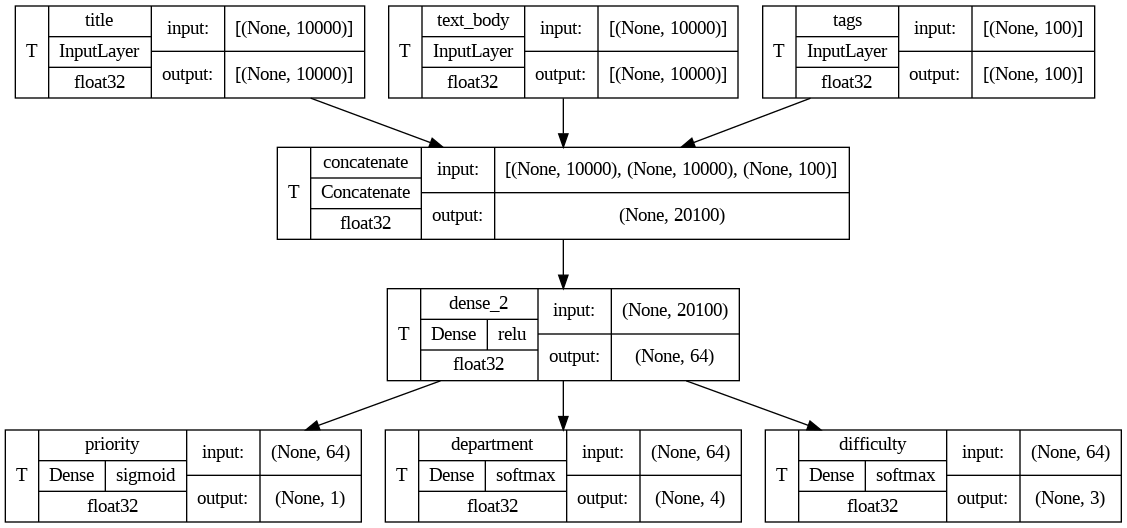

In [20]:
keras.utils.plot_model(
    model = new_model,
    # to_file = "model.png",
    show_shapes = True,
    show_dtype = True,
    show_layer_names = True,
    show_layer_activations = True,
    show_trainable = True
    )

# Subclassing

- 순전파 연산 과정은 `Model.call()` 메소드에 은닉되므로 완전한 블랙박스가 됨
- 때문에 `Model.summary()` 및 `tensorflow.keras.utils.plot_model(Model)` 을 활용할 수 없음

In [21]:
class CustomerTicketModel(Model):

    # 생성자
    def __init__(self, num_departments):
        # tensorflow.keras.Model 필드 상속
        super().__init__()
        # 병합층, 은닉층, 출력층을 필드로 설정
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(units = 64, activation = "relu")
        self.priority_scorer = layers.Dense(units = 1, activation = "sigmoid")
        self.department_classifier = layers.Dense(units = num_departments, activation = "softmax")

    # 순전파 연산
    def call(self, inputs):
        # 입력값이 title, text_body, tags 를 key 로 가지는 dict 임을 전제함
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]
        # 순전파 연산
        concats = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(concats)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [22]:
model = CustomerTicketModel(num_departments = 4)

In [23]:
inputs = {
    "title":title_data,
    "text_body":text_body_data,
    "tags":tags_data
    }

priority, department = model(inputs)

# 여러 방법 혼합하여 사용하기

## 서브클래싱한 모델을 포함하는 함수형 모델

In [39]:
class Classifier(Model):
    def __init__(self, num_class=2):
        super().__init__()
        if num_class == 2:
            num_units = 1
            activation = 'sigmoid'
        else:
            num_units = num_class
            activation = 'softmax'
        self.dense = layers.Dense(num_units, activation = activation)

    def call(self, inputs):
        return self.dense(inputs)

In [40]:
inputs = layers.Input(shape = (3,))
features = layers.Dense(units = 64, activation = "relu")(inputs)
outputs = Classifier(num_class = 10)(features)

In [41]:
model = Model(
    inputs = inputs,
    outputs = outputs,
    name = "Functional_with_Subclassing"
    )

## 함수형 모델을 포함하는 서브클래싱 모델

In [42]:
inputs = layers.Input(shape = (64,))
outputs = layers.Dense(units = 1, activation = "sigmoid")(inputs)
binary_classifier = Model(
    inputs = inputs,
    outputs = outputs
    )

In [43]:
class MyModel(Model):
    def __init__(self, num_class = 2):
        super().__init__()
        self.dense = layers.Dense(units = 64, activation = "relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

In [44]:
model = MyModel()